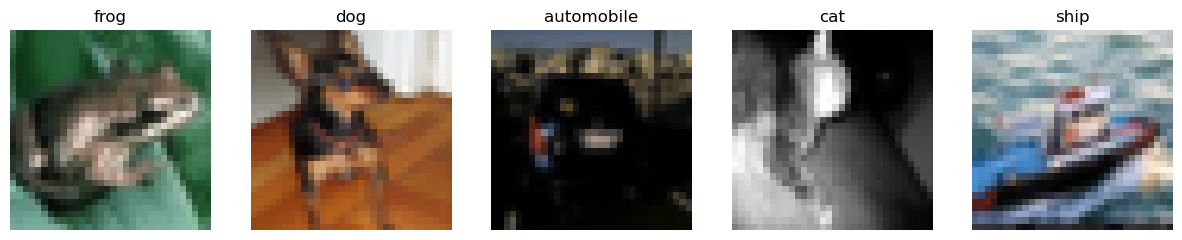

In [23]:
# Cell 1: Setup paths
import sys
import os
import matplotlib.pyplot as plt
import random

# Add the project root to system path so we can import from 'src'
# This allows the notebook to see the 'src' folder one level up
sys.path.append(os.path.abspath('..'))

from src.data.cifar_loader import load_cifar_batch, get_label_names

# Cell 2: Load Data
# Update this path to where your data actually sits on your computer
data_root = '/Users/daulet/Desktop/data centric ai/cifar-10-batches-py'
batch_1_path = os.path.join(data_root, 'data_batch_1')

images, labels = load_cifar_batch(batch_1_path)
label_names = get_label_names(data_root)

# Cell 3: Visualize
plt.figure(figsize=(15, 3))
random_indices = random.sample(range(len(images)), 5)

for i, idx in enumerate(random_indices):
    plt.subplot(1, 5, i + 1)
    plt.imshow(images[idx])
    plt.title(label_names[labels[idx]])
    plt.axis('off')
plt.show()

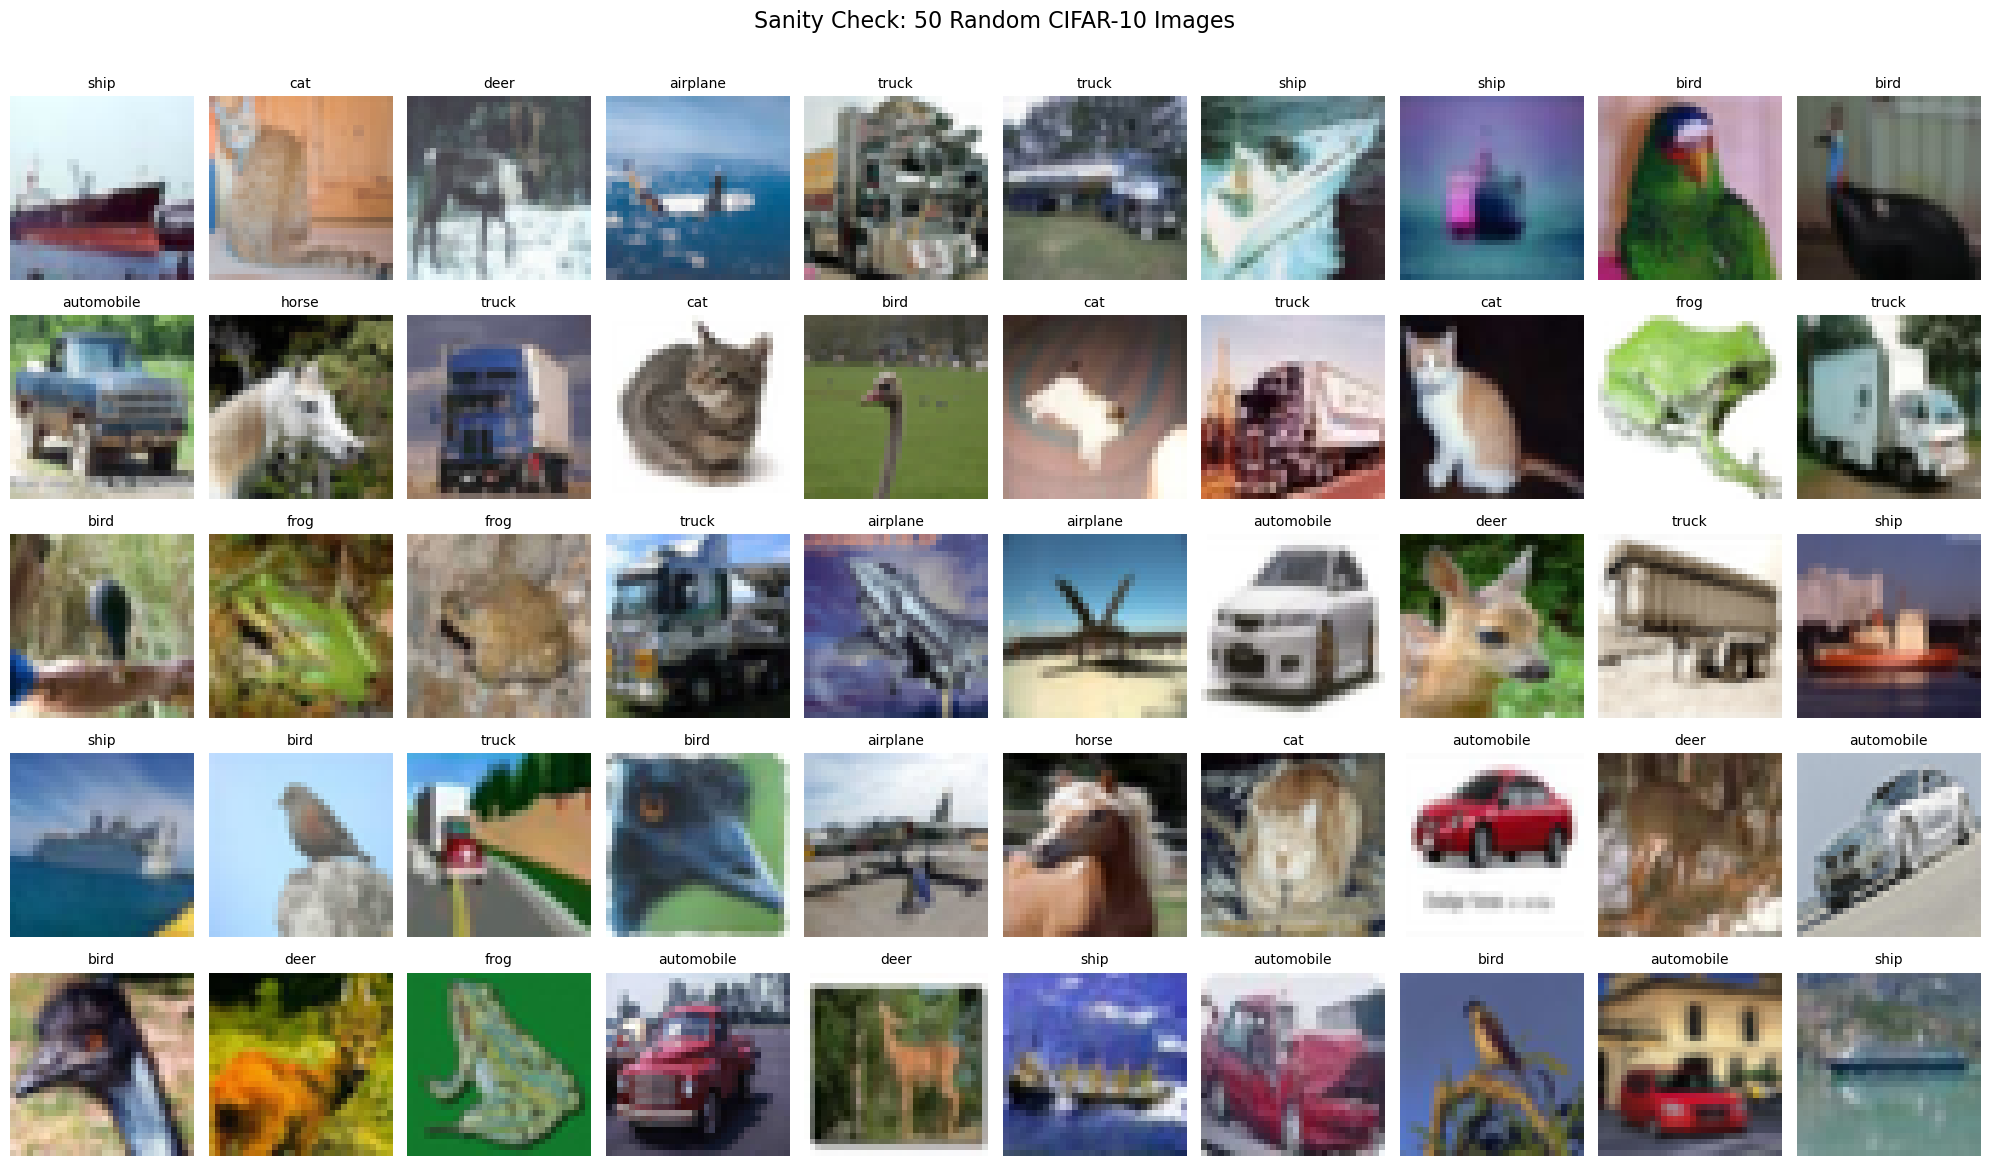

In [25]:
import sys
import os
import matplotlib.pyplot as plt
import random

# Ensure we can see the 'src' folder
sys.path.append(os.path.abspath('..'))

from src.data.cifar_loader import load_cifar_batch, get_label_names

# 1. Load Data
data_root = '/Users/daulet/Desktop/data centric ai/cifar-10-batches-py'
batch_file = os.path.join(data_root, 'data_batch_1')

images, labels = load_cifar_batch(batch_file)
label_names = get_label_names(data_root)

# 2. Setup the 50-Image Grid
# We will do 5 rows of 10 images each
rows = 5
cols = 10
fig, axes = plt.subplots(rows, cols, figsize=(20, 12))
fig.suptitle('Sanity Check: 50 Random CIFAR-10 Images', fontsize=16)

# Pick 50 random indices
random_indices = random.sample(range(len(images)), 50)

for i, ax in enumerate(axes.flat):
    idx = random_indices[i]
    
    # Display image
    ax.imshow(images[idx])
    
    # Get label
    label_id = labels[idx]
    text_label = label_names[label_id]
    
    # Style the plot
    ax.set_title(f"{text_label}", fontsize=10)
    ax.axis('off')

plt.tight_layout()
plt.subplots_adjust(top=0.92) # Make space for the main title
plt.show()

Training on: mps
Loading data...
Starting training...
Epoch 1/5, Loss: 1.6408
Epoch 2/5, Loss: 1.2568
Epoch 3/5, Loss: 1.0054
Epoch 4/5, Loss: 0.8337
Epoch 5/5, Loss: 0.6595
Finished Training!


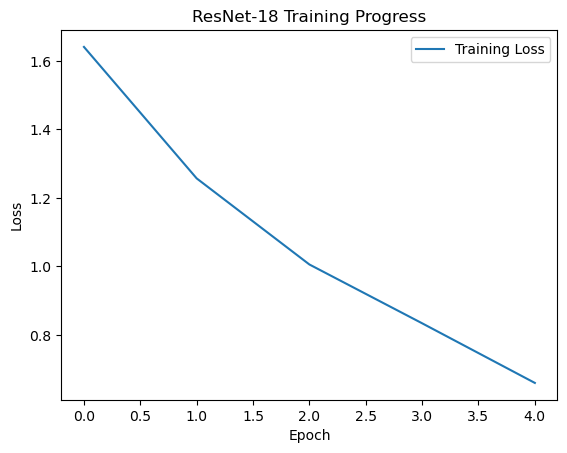

In [27]:
import sys
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# 1. Setup Path to find 'src'
# This points to the parent directory so we can see 'src'
sys.path.append(os.path.abspath('..'))

# 2. Import your actual modules
from src.data.cifar_loader import load_cifar_batch
from src.models.resnet import ResNet18CIFAR  # Using the new ResNet we just made!

# 3. Configuration
BATCH_SIZE = 64
LEARNING_RATE = 0.001
EPOCHS = 5
DATA_PATH = '/Users/daulet/Desktop/data centric ai/cifar-10-batches-py' # Your path

# 4. Check Device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Training on: {device}")

# 5. Load Data (Batch 1 for testing)
print("Loading data...")
batch_file = os.path.join(DATA_PATH, 'data_batch_1')
images, labels = load_cifar_batch(batch_file)

# Prepare for PyTorch (N, H, W, C) -> (N, C, H, W)
images = images.transpose(0, 3, 1, 2)
x_train = torch.tensor(images, dtype=torch.float32) / 255.0
y_train = torch.tensor(labels, dtype=torch.long)

dataset = TensorDataset(x_train, y_train)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# 6. Initialize Model
model = ResNet18CIFAR(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# 7. Training Loop (with live printout)
print("Starting training...")
loss_history = []

for epoch in range(EPOCHS):
    running_loss = 0.0
    for i, (inputs, targets) in enumerate(loader):
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    avg_loss = running_loss / len(loader)
    loss_history.append(avg_loss)
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {avg_loss:.4f}")

print("Finished Training!")

# 8. (Bonus) Plot the Loss Curve directly in the notebook
import matplotlib.pyplot as plt
plt.plot(loss_history, label='Training Loss')
plt.title('ResNet-18 Training Progress')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

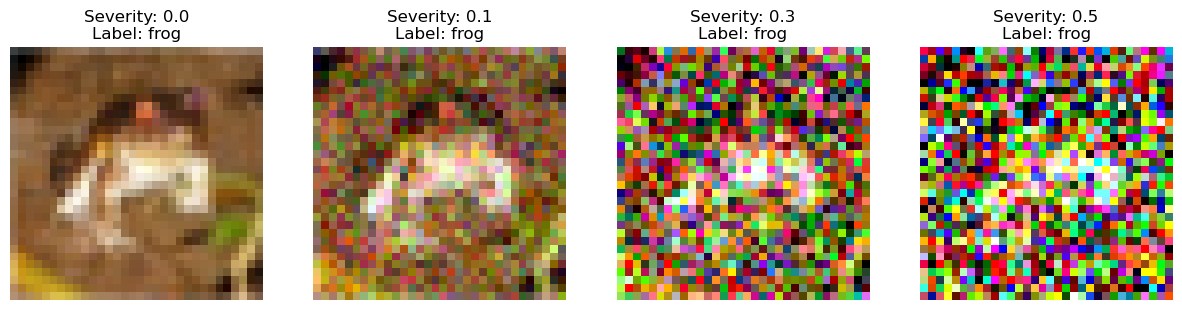

In [29]:
import sys
import os
import torch
import matplotlib.pyplot as plt

# 1. Setup imports
sys.path.append(os.path.abspath('..'))
from src.data.cifar_loader import load_cifar_batch, get_label_names
from src.data.image_noise import add_gaussian_noise

# 2. Load one batch of data
data_root = '/Users/daulet/Desktop/data centric ai/cifar-10-batches-py' # Your path
batch_file = os.path.join(data_root, 'data_batch_1')
images, labels = load_cifar_batch(batch_file)
label_names = get_label_names(data_root)

# 3. Pick a specific image (e.g., Index 0 is usually a Frog in Batch 1)
img_idx = 0 
clean_img_np = images[img_idx] # This is numpy (32, 32, 3)

# Convert to PyTorch Tensor for our function: (H, W, C) -> (C, H, W)
clean_tensor = torch.tensor(clean_img_np).permute(2, 0, 1).float() / 255.0

# 4. Define the levels we want to test
noise_levels = [0.0, 0.1, 0.3, 0.5]

# 5. Plot them side-by-side
plt.figure(figsize=(15, 5))

for i, severity in enumerate(noise_levels):
    # Apply the noise function you just wrote
    noisy_tensor = add_gaussian_noise(clean_tensor, severity)
    
    # Convert back to Numpy for plotting: (C, H, W) -> (H, W, C)
    noisy_img_np = noisy_tensor.permute(1, 2, 0).numpy()
    
    # Plot
    plt.subplot(1, 4, i+1)
    plt.imshow(noisy_img_np)
    plt.title(f"Severity: {severity}\nLabel: {label_names[labels[img_idx]]}")
    plt.axis('off')

plt.show()

In [31]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import os

# 1. Load the Test Data (The official 'test_batch')
DATA_PATH = '/Users/daulet/Desktop/data centric ai/cifar-10-batches-py'
test_batch_file = os.path.join(DATA_PATH, 'test_batch')

print("Loading test data...")
# Load the raw files using your loader
test_images, test_labels = load_cifar_batch(test_batch_file)

# 2. Preprocess (Same rules as training: Transpose and Normalize)
# Convert (N, 32, 32, 3) -> (N, 3, 32, 32)
test_images = test_images.transpose(0, 3, 1, 2)

# Create the variables (This fixes your NameError!)
x_test = torch.tensor(test_images, dtype=torch.float32) / 255.0
y_test = torch.tensor(test_labels, dtype=torch.long)

# 3. Evaluation Loop
model.eval() # Set model to "test mode"
correct = 0
total = 0

# We don't need gradients for testing (saves memory)
with torch.no_grad():
    # Use a DataLoader to process 64 images at a time
    test_loader = DataLoader(TensorDataset(x_test, y_test), batch_size=64, shuffle=False)
    
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        
        # The model gives scores for 10 classes. We pick the highest score.
        _, predicted = torch.max(outputs.data, 1)
        
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

# 4. Print the Score
accuracy = 100 * correct / total
print(f'Final Test Accuracy: {accuracy:.2f}%')

Loading test data...
Final Test Accuracy: 64.58%


Starting Stress Test...
Noise Level 0.0 -> Accuracy: 64.58%
Noise Level 0.1 -> Accuracy: 43.57%
Noise Level 0.2 -> Accuracy: 17.65%
Noise Level 0.3 -> Accuracy: 14.15%
Noise Level 0.4 -> Accuracy: 14.69%
Noise Level 0.5 -> Accuracy: 14.47%
Noise Level 0.6 -> Accuracy: 13.56%
Noise Level 0.7 -> Accuracy: 13.21%
Noise Level 0.8 -> Accuracy: 12.59%
Noise Level 0.9 -> Accuracy: 11.83%
Noise Level 1.0 -> Accuracy: 11.30%


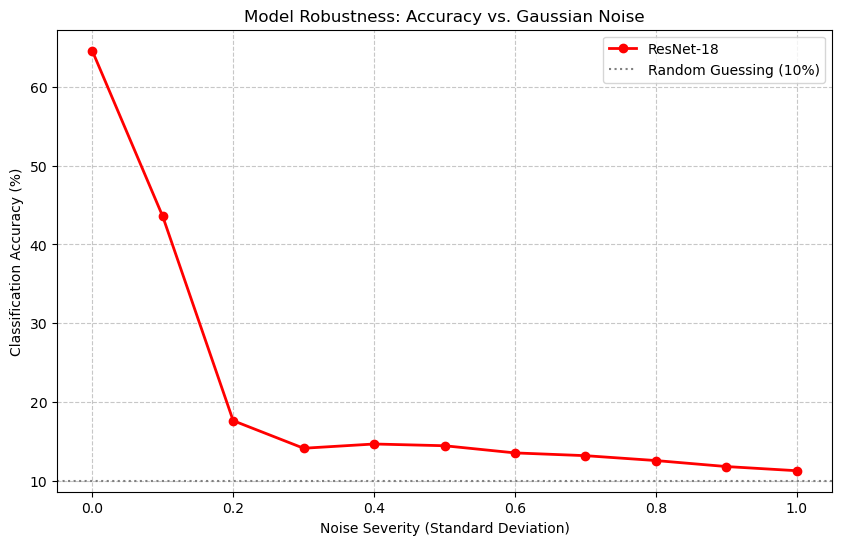

In [35]:
import numpy as np

# 1. Define the range of noise levels to test
# We go from 0.0 (Clean) to 1.0 (Total Garbage) in steps of 0.1
noise_levels = np.linspace(0.0, 1.0, 11) 
accuracies = []

print("Starting Stress Test...")

# Ensure model is in eval mode (no training!)
model.eval()

# 2. The Experiment Loop
with torch.no_grad(): # Disable gradient calculation to speed it up
    for severity in noise_levels:
        correct = 0
        total = 0
        
        # Iterate over the Test Loader (using the test data we loaded earlier)
        # Note: We reuse x_test and y_test from the previous step
        # Create a temporary loader for this specific noise level
        
        # OPTIMIZATION: Instead of reloading data, we apply noise to the batch on the fly
        test_dataset = TensorDataset(x_test, y_test)
        test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
        
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            # --- CRITICAL: Apply Noise Here ---
            noisy_inputs = add_gaussian_noise(inputs, severity)
            # ----------------------------------
            
            outputs = model(noisy_inputs)
            _, predicted = torch.max(outputs.data, 1)
            
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
            
        acc = 100 * correct / total
        accuracies.append(acc)
        print(f"Noise Level {severity:.1f} -> Accuracy: {acc:.2f}%")

# 3. Plot the Results (The Thesis Graph)
plt.figure(figsize=(10, 6))
plt.plot(noise_levels, accuracies, marker='o', linestyle='-', color='r', linewidth=2, label='ResNet-18')
plt.title('Model Robustness: Accuracy vs. Gaussian Noise')
plt.xlabel('Noise Severity (Standard Deviation)')
plt.ylabel('Classification Accuracy (%)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.axhline(y=10, color='gray', linestyle=':', label='Random Guessing (10%)') # Baseline for failure
plt.legend()
plt.show()

In [ ]:
Blur Noise

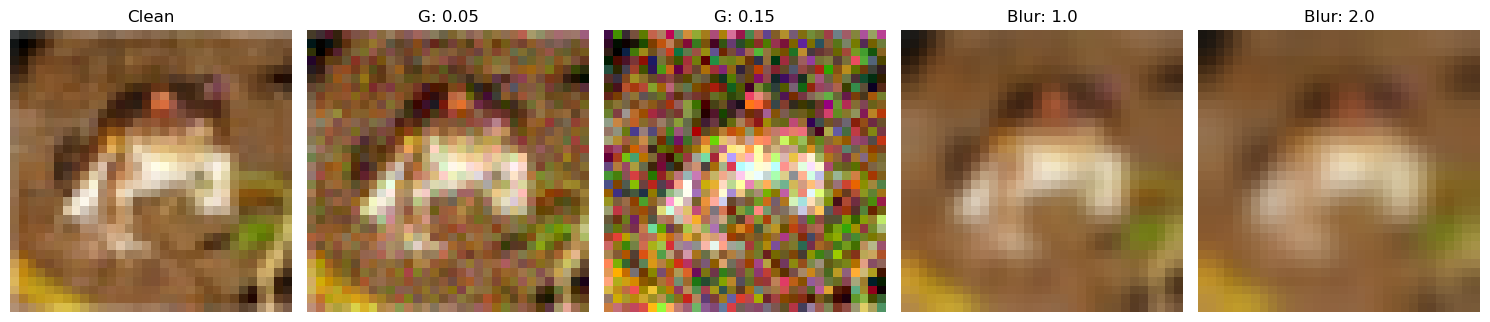

In [11]:
import sys
import os
import torch
import matplotlib.pyplot as plt

# 1. Setup path to find 'src' (Go up one folder)
sys.path.append(os.path.abspath('..'))

from src.data.cifar_loader import load_cifar_batch, get_label_names
# Now we can import BOTH noise types
from src.data.image_noise import add_gaussian_noise, add_blur_noise

# 2. Load one image (A Frog from Batch 1)
data_root = '/Users/daulet/Desktop/data centric ai/cifar-10-batches-py'
batch_file = os.path.join(data_root, 'data_batch_1')
images, labels = load_cifar_batch(batch_file)
label_names = get_label_names(data_root)

img_idx = 0
# Convert to PyTorch Tensor: (H, W, C) -> (C, H, W) and scale to 0-1
clean_tensor = torch.tensor(images[img_idx]).permute(2, 0, 1).float() / 255.0

# 3. Create the Comparison Plot
fig, axes = plt.subplots(1, 5, figsize=(15, 4))
titles = ["Clean", "G: 0.05", "G: 0.15", "Blur: 1.0", "Blur: 2.0"]

# -- Clean --
axes[0].imshow(clean_tensor.permute(1, 2, 0).numpy())

# -- Gaussian (Static) --
g_low = add_gaussian_noise(clean_tensor, 0.05)
axes[1].imshow(g_low.permute(1, 2, 0).numpy())

g_high = add_gaussian_noise(clean_tensor, 0.15)
axes[2].imshow(g_high.permute(1, 2, 0).numpy())

# -- Blur (Smear) --
b_low = add_blur_noise(clean_tensor, 1.0)
axes[3].imshow(b_low.permute(1, 2, 0).numpy())

b_high = add_blur_noise(clean_tensor, 2.0)
axes[4].imshow(b_high.permute(1, 2, 0).numpy())

# Style the plot
for i, ax in enumerate(axes):
    ax.set_title(titles[i])
    ax.axis('off')

plt.tight_layout()
plt.show()

Starting The Showdown (Attempt 2 - Corrected)...
Testing Gaussian (Texture)...
   Severity 0.00 -> Acc: 62.57%
   Severity 0.03 -> Acc: 61.08%
   Severity 0.06 -> Acc: 55.14%
   Severity 0.09 -> Acc: 48.03%
   Severity 0.12 -> Acc: 41.52%
   Severity 0.15 -> Acc: 35.00%
Testing Blur (Shape)...
   Severity 0.00 -> Acc: 62.57%
   Severity 0.40 -> Acc: 61.52%
   Severity 0.80 -> Acc: 41.83%
   Severity 1.20 -> Acc: 33.69%
   Severity 1.60 -> Acc: 31.04%
   Severity 2.00 -> Acc: 30.30%


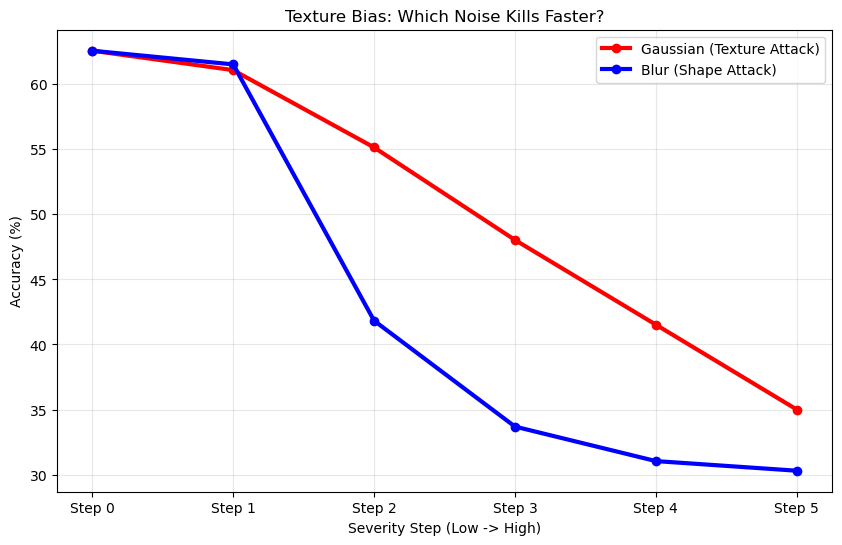

In [21]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt

# 1. Reuse the model and data already in memory 
# (We don't need to re-train, just re-test)

print("Starting The Showdown (Attempt 2 - Corrected)...")
model.eval()

steps = 6
gaussian_levels = np.linspace(0.0, 0.15, steps) 
blur_levels = np.linspace(0.0, 2.0, steps)      

gaussian_acc = []
blur_acc = []

# Loop 1: Gaussian
print("Testing Gaussian (Texture)...")
with torch.no_grad():
    for severity in gaussian_levels:
        correct = 0
        total = 0
        # Create a fresh loader to ensure we don't mix things up
        loader = DataLoader(TensorDataset(x_test, y_test), batch_size=64, shuffle=False)
        
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Add Noise
            noisy_inputs = add_gaussian_noise(inputs, severity) 
            
            # --- CORRECTION IS HERE ---
            outputs = model(noisy_inputs) # We now feed the NOISY image
            # --------------------------
            
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
        
        acc = 100 * correct / total
        gaussian_acc.append(acc)
        print(f"   Severity {severity:.2f} -> Acc: {acc:.2f}%")

# Loop 2: Blur
print("Testing Blur (Shape)...")
with torch.no_grad():
    for severity in blur_levels:
        correct = 0
        total = 0
        loader = DataLoader(TensorDataset(x_test, y_test), batch_size=64, shuffle=False)
        
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Add Noise
            noisy_inputs = add_blur_noise(inputs, severity) 
            
            # --- CORRECTION IS HERE ---
            outputs = model(noisy_inputs) # We now feed the NOISY image
            # --------------------------
            
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
        
        acc = 100 * correct / total
        blur_acc.append(acc)
        print(f"   Severity {severity:.2f} -> Acc: {acc:.2f}%")

# Plot
plt.figure(figsize=(10, 6))
step_indices = range(steps)
plt.plot(step_indices, gaussian_acc, 'r-o', linewidth=3, label='Gaussian (Texture Attack)')
plt.plot(step_indices, blur_acc, 'b-o', linewidth=3, label='Blur (Shape Attack)')
plt.title('Texture Bias: Which Noise Kills Faster?')
plt.xlabel('Severity Step (Low -> High)')
plt.ylabel('Accuracy (%)')
plt.xticks(step_indices, labels=["Step 0", "Step 1", "Step 2", "Step 3", "Step 4", "Step 5"])
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()